# Simulation of a carbon fiber reinforced wing foil mast 
The introduction of foils brought exiting innovation to many water sport activities, such as sailing, wind surfing and kite boarding. A particularly new activity called "wing foiling" emerged with the advent of new technologies and materials. During wing foiling, an athlete holds a kite-like wing in the hands for propulsion while standing on a surf board that is seemingly flying above the water surface. This is achieved with a underwater wing generating lift, which is connected to the board via a lightweight mast. 


![Wing foil](https://www.kingofwatersports.com/dam/jcr:ecf639a7-8247-4df5-85ef-8d003d0ccbcf/wing-foil-guide-3.jpg)


In this workshop, we want to simulate the deformation of a carbon fiber reinforced wing foil mast under loading via finite elements. We will simplify the 3D geometry to a 2D rectangle in this workshop.

![Foil model](./docs/foil.png)

**Assumptions and simplifications**
- The entire problem is planar, i.e. the geometry, all loads and all displacements lay within a 2D plane
- We assume a plane-stress state, i.e. there is no stress perpendicular to the plane of interest, as the component may contract in this direction freely
- The deformations are small
- The material is linear elastic and homogeneous, but not isotropic

**Requirements**
- Python installation with Jupyter notebook 
- Installation of the scikit-fem package, e.g. via `pip install scikit-fem`

This cell should execute successfully, if your installation is working:

In [1]:
import skfem
import numpy as np

## Material model
Our carbon fiber material is a linear, elastic, homogeneous and anisotropic material. If we assume a plane stress state, we may write the relation between stress and strain (material model) in terms of the compliance tensor 
$$
\begin{pmatrix}
    \varepsilon_{xx}\\
    \varepsilon_{yy}\\
    2\varepsilon_{xy}
\end{pmatrix}
=
\begin{pmatrix}
    \frac{1}{E_{xx}} & -\frac{\nu_{xy}}{E_{xx}} & 0\\
    -\frac{\nu_{yx}}{E_{yy}} & \frac{1}{E_{yy}} & 0\\
    0 & 0 & \frac{1}{G_{xy}}
\end{pmatrix}
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}
$$
or as stiffness tensor 
$$
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}
=
\begin{pmatrix}
    \frac{E_{xx}}{1-\nu_{xy}\nu_{yx}} & \frac{\nu_{xy}E_{yy}}{1-\nu_{xy}\nu_{yx}} & 0\\
    \frac{\nu_{yx}E_{xx}}{1-\nu_{xy}\nu_{yx}}& \frac{E_{yy}}{1-\nu_{xy}\nu_{yx}} & 0\\
    0 & 0 & G_{xy}
\end{pmatrix}
\begin{pmatrix}
    \varepsilon_{xx}\\
    \varepsilon_{yy}\\
    2\varepsilon_{xy}
\end{pmatrix}
$$

The stiffness is characterized by four properties $E_{xx}, E_{yy}, G_{xy}, \nu_{xy}$. The tensor is symmetric with 
$$ \frac{\nu_{xy}}{E_{xx}}=\frac{\nu_{yx}}{E_{yy}} $$

In [2]:
# From DIC evaluation
E_xx = 59667.0
E_yy = 59625.0
G_xy = 11817.0
nu_xy = 0.054
nu_yx = E_yy/E_xx * nu_xy

# Stiffness matrix
C = np.array(
[
    [E_xx / (1.0 - nu_xy * nu_yx), nu_xy * E_yy / (1.0 - nu_xy * nu_yx), 0.0],
    [nu_yx * E_xx / (1.0 - nu_xy * nu_yx), E_yy / (1.0 - nu_xy * nu_yx), 0.0],
    [0.0, 0.0, G_xy],
]
)

## Rotational transformation matrix 
The matrix entries in stress and strain tensors may vary if we rotate the frame of reference. We can use the rotation matrix 
$$
\bm{R} (\phi)
=
\begin{pmatrix}
    \cos^2{\phi} & \sin^2{\phi} & 2\sin{\phi}\cos{\phi}\\
    \sin^2{\phi} & \cos^2{\phi} & -2\sin{\phi}\cos{\phi}\\
    -\sin{\phi}\cos{\phi} & \sin{\phi}\cos{\phi} & \cos^2{\phi}-\sin^2{\phi}
\end{pmatrix}
$$

to perform an in-plane rotation by $\phi$ by computing 

$$
\begin{pmatrix}
    \sigma_{xx}'\\
    \sigma_{yy}'\\
    \sigma_{xy}'
\end{pmatrix}
= 
\bm{R} (\phi)
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}
$$

Note that this matrix is not symmetrical due to the convention of writing $\gamma_{xy}=2\varepsilon_{xy}$ for the shear stress. This is rooted in the definition of the shear modulus $\sigma_{xy}=G\gamma_{xy}$.

In [3]:
def R(phi):
    return np.array([[np.cos(phi)**2, np.sin(phi)**2, 2*np.sin(phi)*np.cos(phi)],
                     [np.sin(phi)**2, np.cos(phi)**2, -2*np.sin(phi)*np.cos(phi)],
                     [-np.sin(phi)*np.cos(phi), np.sin(phi)*np.cos(phi), np.cos(phi)**2-np.sin(phi)**2]])

Now, we use the rotation matrix to compute the rotated stiffness tensor $\bm{C}_{rot}$ according to 
$$\bm{C}_{rot} = \bm{R}(\phi) \bm{C} \bm{R}^\top(\phi).$$

With $\bm{C}_{rot}$, we can write a function that takes strain as a numpy array of the shape `2 x 2 x n_elements x n_quadrature_points` and the rotation angle to compute the corresponding stress in the same shape as the strain tensor. To do so, we reshape the strain to a shape `3 x n_elements x n_quadrature_points` and compute the matrix vector product with $C$. The result is a `3 x n_elements x n_quadrature_points` stress, which we reshape to the desired output shape. This could be done more elegantly, if we'd use a four dimensional stiffness matrix, but that is tricky in terms of notation.

In [4]:
def sigma(eps, phi):
    # eps: 2 x 2 x n_element x n_quadrature_points
    epsilon = np.array([eps[0,0], eps[1,1], 2.0 * eps[0,1]])
    C_rot = R(phi) @ C @ R(phi).T
    sigma = np.einsum('ij,j...->i...', C_rot, epsilon)
    return np.array([[sigma[0], sigma[2]], [sigma[2], sigma[1]]])

## Geometry
In a next step, we need to create the geometry and discretize it to finite elements. At this point, we could import any complex 3D model via `skfem.mesh.load()`. For the simplified geometry at hand, we can generate the mesh with a few lines of code:

In [5]:
# Mast width, height and thickness
W = 100.0
H = 800.0 
T = 2.0

# Mesh size
s = 5.0

# Create a mesh
x = np.linspace(0, W, int(W/s) + 1)
y = np.linspace(0, H, int(H/s) + 1)
mesh = skfem.MeshQuad().init_tensor(x,y)

# Label the boundaries
mesh = mesh.with_boundaries(
    {
        "bottom": lambda x: np.isclose(x[1], 0.0),
        "top": lambda x: np.isclose(x[1], H),
    }
)
print(mesh)

<skfem MeshQuad1 object>
  Number of elements: 3200
  Number of vertices: 3381
  Number of nodes: 3381
  Named boundaries [# facets]: bottom [20], top [20]


## Element type
We use first order quadrilateral elements, which are combined in an element vector of dimension two, as we have two solution variables ($u_x$ and $u_y$). If we want to switch to another element type (different order, different shape or different integration), we have to adjust this line and the mesh generation in the previous cell. However, mesh generation is not trivial and you may use external tools like gmsh for this task.

In [6]:
element = skfem.ElementVector(skfem.ElementQuad1(), 2)

## Basis
A basis is the combination of element and mesh. It enables interpolations and projections between the discrete nodal data and the continuous solution field.

In [7]:
# Domain
basis = skfem.Basis(mesh, element)

# Boundary
bottom_basis = skfem.FacetBasis(mesh, element, facets=mesh.boundaries["bottom"])

## Dirichlet boundary condition
The top nodes are fixed in all directions. Hence, we summarize the corresponding degrees of freedom (DOFs) in a variable `cons`, which will be later used to eliminate these DOFs when solving the system equations.

In [8]:
cons = basis.get_dofs({"top"})

## Weak form of the momentum balance

$$ T \int_\Omega \sigma \left (\nabla^s u \right) : \nabla^s v dV = \int_\Gamma t \cdot v dA$$

with $T$ denoting the thickness.

In [9]:
from skfem.helpers import ddot, dot, sym_grad

@skfem.BilinearForm
def k(u, v, w):
    return T * ddot(sigma(sym_grad(u), w.orientation), sym_grad(v))

@skfem.LinearForm
def b(v, w):
    t = np.array([2.0, 10.0])
    return dot(t, v)

## Assembly 
This is the key feature of the scikit-fem package. Using a basis and a form, it assembles the stiffness matrix `K` and the right hand side vector `B`. Subsequently, we condense the system by eliminating the DOFs of Dirichlet BCs (we know those values by definition and it eliminates the singularity of K, if chosen properly). The result of the condensation is a reduced stiffness matrix, a reduced right hand side vector and utility variables describing the initial values `u_0` and the included DOFs `I`.

In [10]:
orientation = 0.0
# Assemble matrices
K = skfem.asm(k, basis, orientation=orientation)
B = skfem.asm(b, bottom_basis)

# Eliminate DOFs
K_red, B_red, u_0, I = skfem.condense(K, B, D=cons)


## Solve
We solve the system with a suitable sparse-matrix solver. Once we have the matrices, we could use any solver and backend we like.

In [11]:
u = skfem.solve(K_red, B_red, u_0, I)

## Visualization of the results 

For visualization, we evaluate the stress at integration points. To do so, we interpolate the nodal displacement data with the basis (this includes the evaluation of displacement gradients at the integration points). With the (symmetric) gradient, we compute stresses at integration points and average them for each element for visualization purposes. We can also compute the v. Mises equivalent stress.

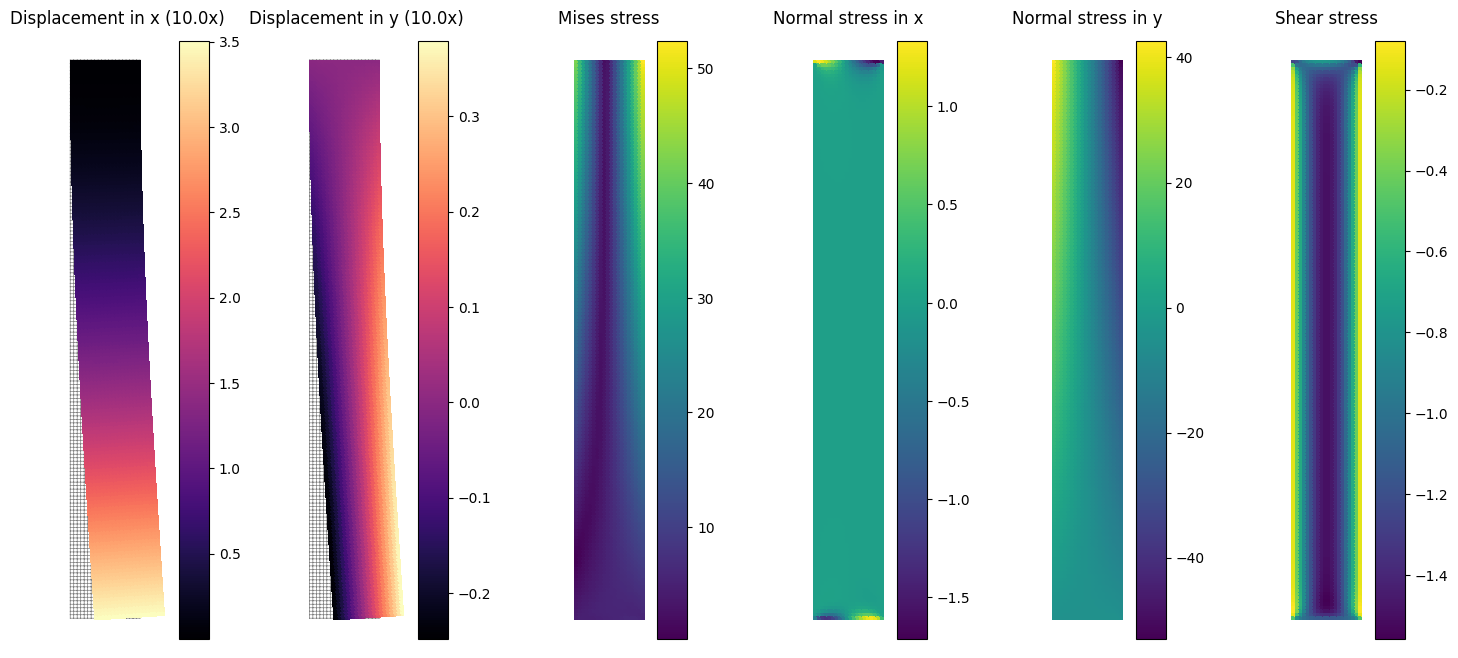

In [12]:
from skfem.visuals.matplotlib import plot, draw
import matplotlib.pyplot as plt
import copy

# Compute stress at integration points
ui = basis.interpolate(u)
S = sigma(sym_grad(ui), orientation).mean(axis=-1)
S_mises = np.sqrt(S[0,0]**2 + S[1,1]**2 - S[0,0]*S[1,1] + 3.0*S[0,1]**2)

# Create a cops of the mesh and deform it with a scale factor and the displacement field
scale_factor = 10.0
defmesh = copy.deepcopy(mesh)
defmesh.doflocs[0] += scale_factor * u[basis.nodal_dofs[0]]
defmesh.doflocs[1] += scale_factor * u[basis.nodal_dofs[1]]

# Create a group of 6 plots
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18, 8))

# Plot deformation in x-direction
draw(mesh, ax=ax[0], color="gray", plot_kwargs={"zorder": -1})
plot(defmesh, u[basis.nodal_dofs[0]], ax=ax[0], cmap="magma", colorbar=True)
ax[0].set_title(f"Displacement in x ({scale_factor:.1f}x)")
ax[0].set_aspect("equal")
ax[0].set_axis_off()

# Plot deformation in y-direction
draw(mesh, ax=ax[1], color="gray", plot_kwargs={"zorder": -1})
plot(defmesh, u[basis.nodal_dofs[1]], ax=ax[1], cmap="magma", colorbar=True)
ax[1].set_title(f"Displacement in y ({scale_factor:.1f}x)")
ax[1].set_aspect("equal")
ax[1].set_axis_off()

# Plot Mises stress
plot(mesh, S_mises, ax=ax[2], cmap="viridis", colorbar=True)
ax[2].set_title("Mises stress")
ax[2].set_aspect("equal")
ax[2].set_axis_off()

# Plot Sxx
plot(mesh, S[0,0], ax=ax[3], cmap="viridis", colorbar=True)
ax[3].set_title("Normal stress in x")
ax[3].set_aspect("equal")
ax[3].set_axis_off()

# Plot Syy
plot(mesh, S[1,1], ax=ax[4], cmap="viridis", colorbar=True)
ax[4].set_title("Normal stress in y")
ax[4].set_aspect("equal")
ax[4].set_axis_off()

# Plot Sxy
plot(mesh, S[0,1], ax=ax[5], cmap="viridis", colorbar=True)
ax[5].set_title("Shear stress")
ax[5].set_aspect("equal")
ax[5].set_axis_off()

## Effect of orientation 
Now, we may repeat our computations for different orientation angles of our carbon composite.

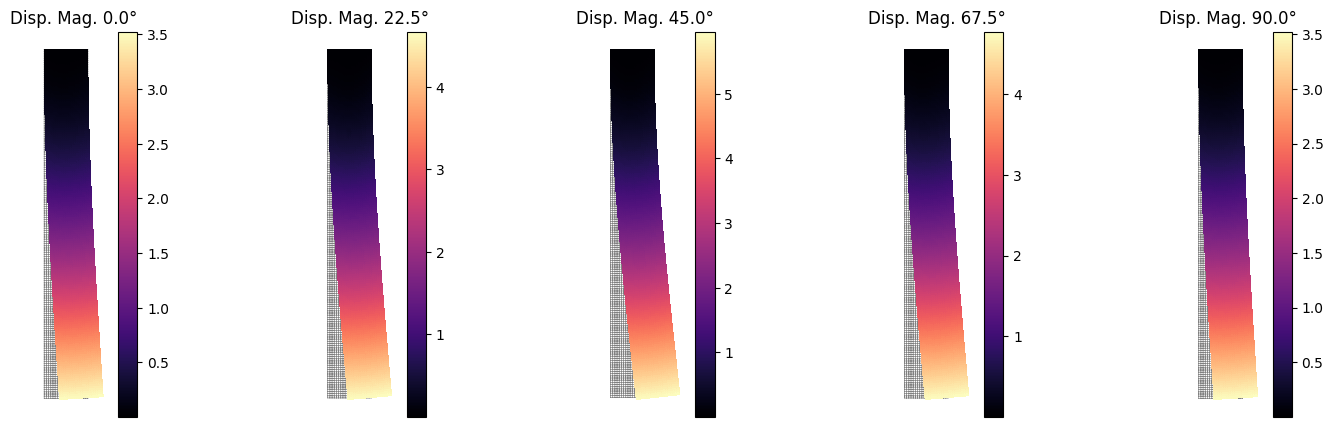

In [13]:
orientations = [0.0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]

fig, ax = plt.subplots(ncols=len(orientations), nrows=1, figsize=(18, 5))

for i, orientation in enumerate(orientations):
    # Solve again for the new orientation
    K = skfem.asm(k, basis, orientation=orientation)
    u = skfem.solve(*skfem.condense(K, B, x=u, I=I))

    # Computed (scaled) deformed mesh
    defmesh = copy.deepcopy(mesh)
    defmesh.doflocs[0] += scale_factor * u[basis.nodal_dofs[0]]
    defmesh.doflocs[1] += scale_factor * u[basis.nodal_dofs[1]]

    # Plot deformation magnitude for the original orientation
    u_mag = np.sqrt(u[basis.nodal_dofs[0]]**2 + u[basis.nodal_dofs[1]]**2)
    draw(mesh, ax=ax[i], color="gray", plot_kwargs={"zorder": -1})
    plot(defmesh, u_mag, ax=ax[i], cmap="magma", colorbar=True)
    ax[i].set_title(f"Disp. Mag. {orientation*180/np.pi}°")
    ax[i].set_aspect("equal")
    ax[i].set_axis_off()


# Tasks 

Some tasks and things to modify...